In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
fileName = '/Users/ranjeetsandhu/Documents/DataScience/Python/Projects_2021/shipFuelConsumption/predict-fuel-consumption/data/interim/indexed-dataFrame.csv'
df = pd.read_csv(fileName, index_col='Time', parse_dates=True)

In [3]:
df.shape

(16248, 25)

In [4]:
df.dropna(how='any', inplace=True)

In [5]:
df.shape

(16084, 25)

In [6]:
df['meanDraft'] = df[['draftAft', 'draftForward', 'draftMid1', 'draftMid2']].mean(axis=1)

In [7]:
# Drop the columns with high number of values zero - MGO, waveDirection, wavePeriod, waveHeight, waterDepth,
# currentDirection, currentSpeed, speedGround. Shaft power is output rather than input, shaft torque is not known
# before, so drop these too. AWS & AWD are dropped as their calculation involves speed of ship.
cols_to_drop = ['MGO', 'draftForward', 'draftAft', 'draftMid1', 'draftMid2', 'shaftTorque', 'shaftPower',
                'speedGround', 'AWS', 'AWD', 'currentDirection', 'currentSpeed', 'waterDepth',
                'waveHeight', 'wavePeriod', 'waveDirection']

df.drop(columns=cols_to_drop, inplace=True)

In [8]:
df.head()

,fuelConsumption,HFO,shaftSpeed,speedWater,heading,rudderAngle,TWS,TWD,temp,meanDraft
Time,,,,,,,,,,
2017-07-06 13:15:00,0.0,0.0,84.878837,15.607449,167.741687,358.025169,6.675341,314.224434,20.283071,2.874424
2017-07-06 14:00:00,0.0,0.0,84.868300,15.776289,168.034239,357.967447,7.034934,308.615477,20.360865,2.877338
2017-07-06 15:00:00,0.0,0.0,84.874972,15.707046,152.496507,358.605730,7.778714,303.563221,20.534437,2.882920
2017-07-06 16:00:00,0.0,0.0,84.867446,15.723442,128.601049,358.864694,8.508143,300.737464,20.641539,2.886406
2017-07-06 17:00:00,0.0,0.0,84.864535,15.692471,107.945165,358.951153,8.541664,302.903406,20.662176,2.887449


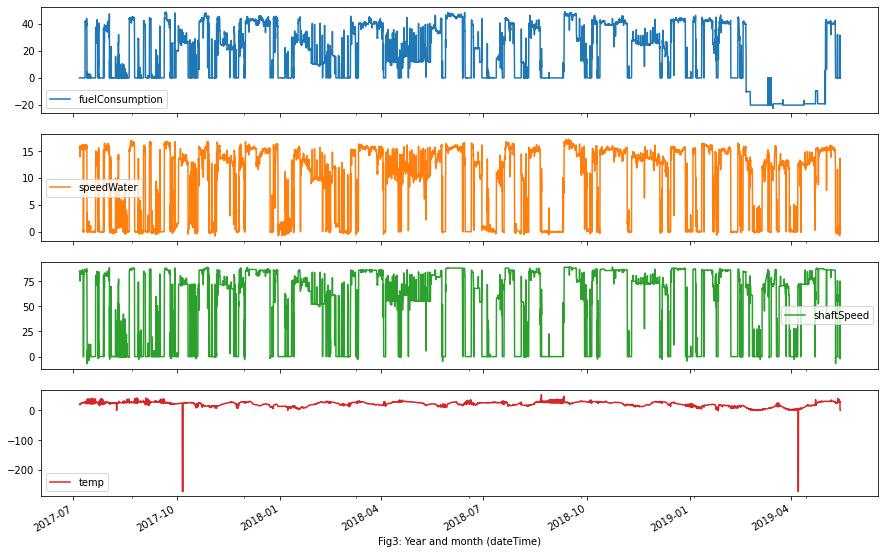

In [9]:
df.loc[:, ['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Fig3: Year and month (dateTime)");

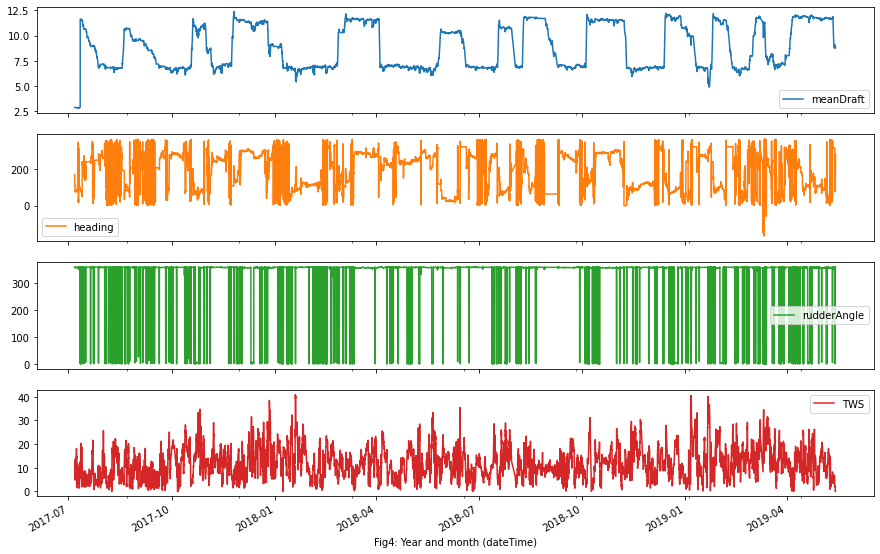

In [10]:
df.loc[:, ['meanDraft', 'heading', 'rudderAngle', 'TWS']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Fig4: Year and month (dateTime)");

In [11]:
# Summary Statistics - before data cleaning
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuelConsumption,16084.0,17.182269,20.758227,-22.565517,-0.048000,15.922000,39.785383,49.090823
HFO,16084.0,0.816453,0.386674,0.000000,1.000000,1.000000,1.000000,1.000000
shaftSpeed,16084.0,50.945466,36.676121,-7.110332,0.000000,69.725568,85.457932,88.959431
speedWater,16084.0,9.238024,6.549276,-0.812132,0.386693,12.443506,15.109174,17.186902
heading,16084.0,182.710216,102.050205,-164.643903,88.550148,205.461343,273.356663,359.824424
rudderAngle,16084.0,323.912261,105.071121,0.000000,357.507311,358.604663,359.113843,359.999195
TWS,16084.0,11.934411,6.385196,0.000000,7.261137,11.268358,15.814307,40.845838
TWD,16084.0,188.118918,113.072684,0.000568,79.045431,199.607859,292.351547,359.997076
temp,16084.0,20.734993,13.686842,-273.150000,16.450906,22.682902,26.866839,52.559168
meanDraft,16084.0,8.813167,2.170238,2.788652,6.839954,8.089915,11.303533,12.385497


In [12]:
# Drop Absolute temp values (observed < -273), which are likely because of sensor error. Drop negative heading
# values and fuel consumption values < -0.5
conditionEval = (df['heading'] < 0) | (df['temp'] < -273) | (df['fuelConsumption'] < -0.5)
df.drop(df[conditionEval].index, inplace=True)
# Replace the Fuel consumption negative values between -0.5 and 0 with zero. These values are likely to be within
# standard error of measurement. Since shaft speed is zero for these values, it is inferred that the ship is
# docked at port.
df.loc[df['fuelConsumption'] < 0, 'fuelConsumption'] = 0

In [13]:
# Summary Statistics - after data cleaning
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuelConsumption,14476.0,21.140653,17.855646,0.000000,0.000000,22.257526,40.218336,49.090823
HFO,14476.0,0.860113,0.346357,0.000000,1.000000,1.000000,1.000000,1.000000
shaftSpeed,14476.0,50.854198,36.941775,-7.110332,0.000000,69.020801,85.516202,88.959431
speedWater,14476.0,9.254994,6.609528,-0.812132,0.398814,12.562894,15.183303,17.186902
heading,14476.0,185.953535,101.859125,0.000000,89.915705,214.587625,275.985261,359.824424
rudderAngle,14476.0,325.009514,103.478682,0.000000,357.465390,358.596363,359.109882,359.999195
TWS,14476.0,11.765030,6.378717,0.000000,7.070607,11.005278,15.635964,40.845838
TWD,14476.0,187.471840,113.782185,0.000568,78.322060,196.893359,293.526962,359.997076
temp,14476.0,22.348846,6.485829,-1.055194,18.101226,23.944502,27.071460,52.559168
meanDraft,14476.0,8.734499,2.154463,2.788652,6.830309,7.926073,11.100352,12.385497


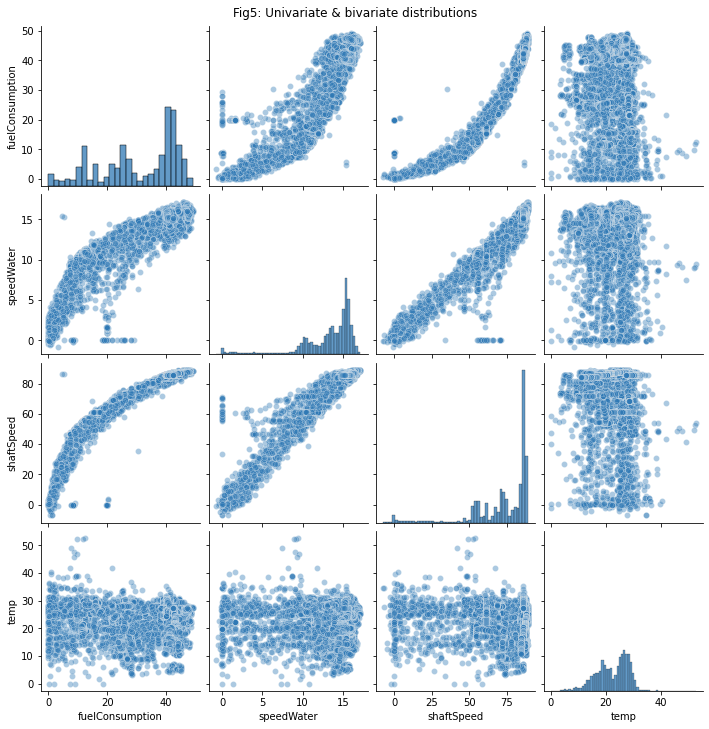

In [14]:
# Pair plot
sns.set_palette("RdBu_r")
g = sns.pairplot(df[df['fuelConsumption'] > 0], vars=['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp'],
                 plot_kws={'alpha': 0.4})
g.fig.suptitle("Fig5: Univariate & bivariate distributions",  y=1.01);

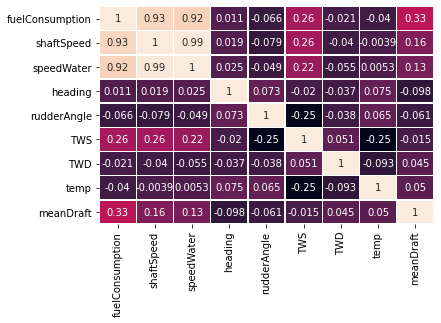

In [15]:
# Correlation Matrix
sns.heatmap(df.drop(columns='HFO').corr(), annot=True, cbar=False, linewidths=0.5);